In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import bbobtorch
import torch
import model 
#from botorch.models import SingleTaskGP
#from botorch.fit import fit_gpytorch_mll
#from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
import gt_sampling
import torch.optim as optim
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
#from soft_dtw import SoftDTW

import torch
import torch.nn as nn
import torch.nn.functional as F

In [32]:
# generate ground truth from BBOB function suite
n_dim = 2
problem_name = "f24"
exec(f"problem = bbobtorch.create_{problem_name}(n_dim, seed=42)")

c:\Users\knoll\anaconda3\envs\MachineLearningProject\lib\site-packages\bbobtorch\utils.py:44: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2431.)
  R, _ = t.qr(R)


In [34]:
samples = gt_sampling.get_sample(f_number=2, n_samples=1000, n_dim=2, seed=42, method='random')

In [35]:
# convert the samples into the right format for the problem:
custom_samples_double = torch.tensor(samples, dtype=torch.float64)
custom_samples_float32 = custom_samples_double.float()

# get the results from the bbob problem:
results = problem(custom_samples_float32)


In [36]:
def plot_sampled_data(samples, results, f_number: str):	
    plt.scatter(samples[:, 0], samples[:, 1], c=results, cmap='inferno', s=1)

    # Add color bar for reference
    colorbar = plt.colorbar()
    colorbar.set_label('Function Value', rotation=270, labelpad=15)

    # Add labels and title
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(f'Custom Samples with Function Values ({f_number})')
    return plt.gca()


In [37]:
def plot_simulated_meshgrid(X, Y, mesh_results, model: str):
    plt.pcolormesh(X, Y, mesh_results, cmap='inferno', shading='nearest')
    plt.colorbar(label='Function Value')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(f'Simulated Function from {model}')


    return plt.gca()

In [38]:
def plot_ground_truth(f_name, xlim=(-5, 5), step=0.01 ):
    ranges = [torch.arange(xlim[0], xlim[1] + step, step=step) for _ in range(n_dim)]
    meshgrid = torch.meshgrid(*ranges)
    points = torch.stack(meshgrid, dim=-1).view(-1, n_dim)

    gt_results = problem(points)

    grid_size = int((xlim[1] - xlim[0]) / step) + 1
    x = points[:, 0].reshape(grid_size, grid_size)
    y = points[:, 1].reshape(grid_size, grid_size)
    z = gt_results.reshape(grid_size, grid_size)

    # Create a pcolormesh plot
    plt.pcolormesh(x, y, z, cmap='inferno', shading='nearest')
    plt.colorbar()
    plt.plot(problem.x_opt[0], problem.x_opt[1], 'rx', markersize=10, label='x_opt')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ground Truth of {f_name} Function')
    return plt.gca()

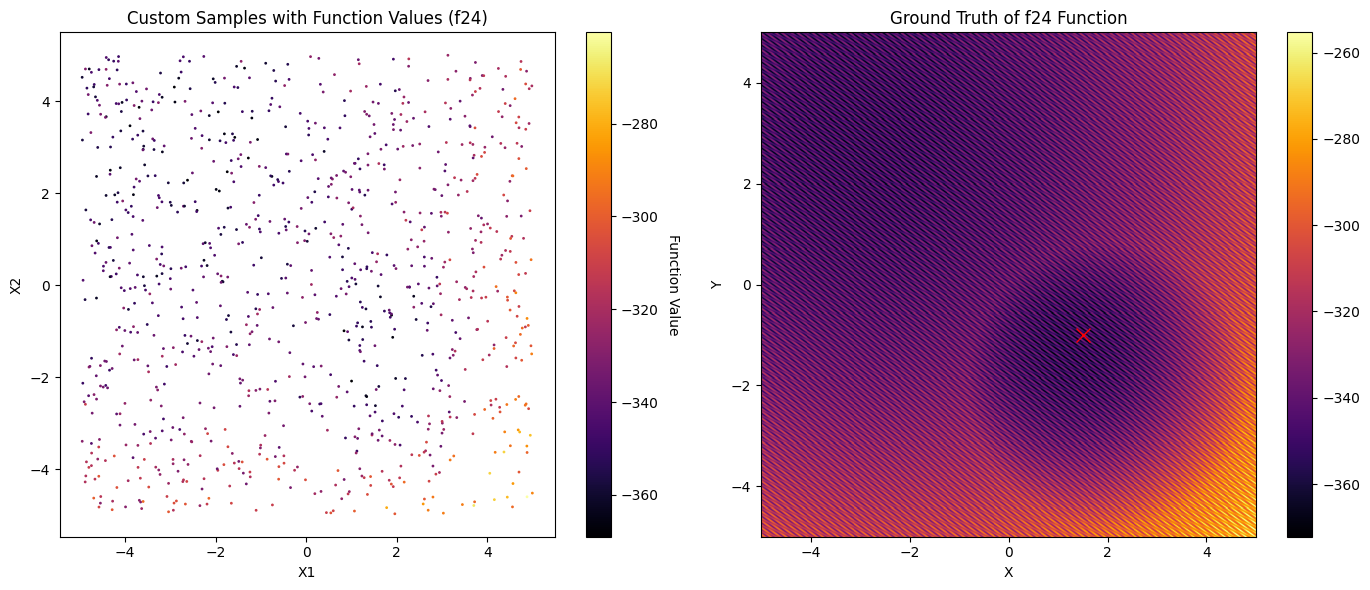

In [39]:
# Create a scatter plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_sampled_data(samples, results, problem_name)

# Plot the ground truth using a contour plot
plt.subplot(1, 2, 2)
plot_ground_truth(f_name=problem_name)

# Show the plot
plt.tight_layout()
plt.show()

## Simulate the function with NN

In [40]:
# simulate the function with the aboth samples and results
X = samples
y = results.float()

# transform numpy arrays to torch tensors
X = torch.tensor(X, dtype=torch.float32).clone().detach()
# y = torch.tensor(y, dtype=torch.float32).clone().detach()

In [41]:
# Train the NN model using the custom samples and their function values
# XXX parameters are taken from chat gpt, need to be changed!
input_dim = 2
hidden_dim = 16
hidden_layers = 4
output_dim = 1
learning_rate = 0.001
num_epochs = 2000

m = model.NN(input_dim, hidden_dim, hidden_layers)
criterion = nn.MSELoss()#nn.GaussianNLLLoss()
optimizer = optim.Adam(m.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5) 

In [42]:
# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = m(X)
    # var = torch.ones(1000, requires_grad=True)  

    loss = criterion(outputs.flatten(), y.flatten()/400)#, var)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_lr()[0]:.6f}')

c:\Users\knoll\anaconda3\envs\MachineLearningProject\lib\site-packages\torch\optim\lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch [10/2000], Loss: 0.3550, Learning Rate: 0.001000
Epoch [20/2000], Loss: 0.2373, Learning Rate: 0.001000
Epoch [30/2000], Loss: 0.1399, Learning Rate: 0.001000
Epoch [40/2000], Loss: 0.0757, Learning Rate: 0.001000
Epoch [50/2000], Loss: 0.0527, Learning Rate: 0.001000
Epoch [60/2000], Loss: 0.0345, Learning Rate: 0.001000
Epoch [70/2000], Loss: 0.0257, Learning Rate: 0.001000
Epoch [80/2000], Loss: 0.0213, Learning Rate: 0.001000
Epoch [90/2000], Loss: 0.0185, Learning Rate: 0.001000
Epoch [100/2000], Loss: 0.0165, Learning Rate: 0.001000
Epoch [110/2000], Loss: 0.0149, Learning Rate: 0.001000
Epoch [120/2000], Loss: 0.0134, Learning Rate: 0.001000
Epoch [130/2000], Loss: 0.0121, Learning Rate: 0.001000
Epoch [140/2000], Loss: 0.0108, Learning Rate: 0.001000
Epoch [150/2000], Loss: 0.0096, Learning Rate: 0.001000
Epoch [160/2000], Loss: 0.0084, Learning Rate: 0.001000
Epoch [170/2000], Loss: 0.0074, Learning Rate: 0.001000
Epoch [180/2000], Loss: 0.0064, Learning Rate: 0.001000
E

In [43]:
# generate mesh grid for plotting
with torch.no_grad():
    x = np.linspace(-5.0, 5.0, 100)
    y = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(x, y)
    mesh_samples = np.c_[X.ravel(), Y.ravel()]
    mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
    mesh_results = m(mesh_samples_tensor).reshape(X.shape)

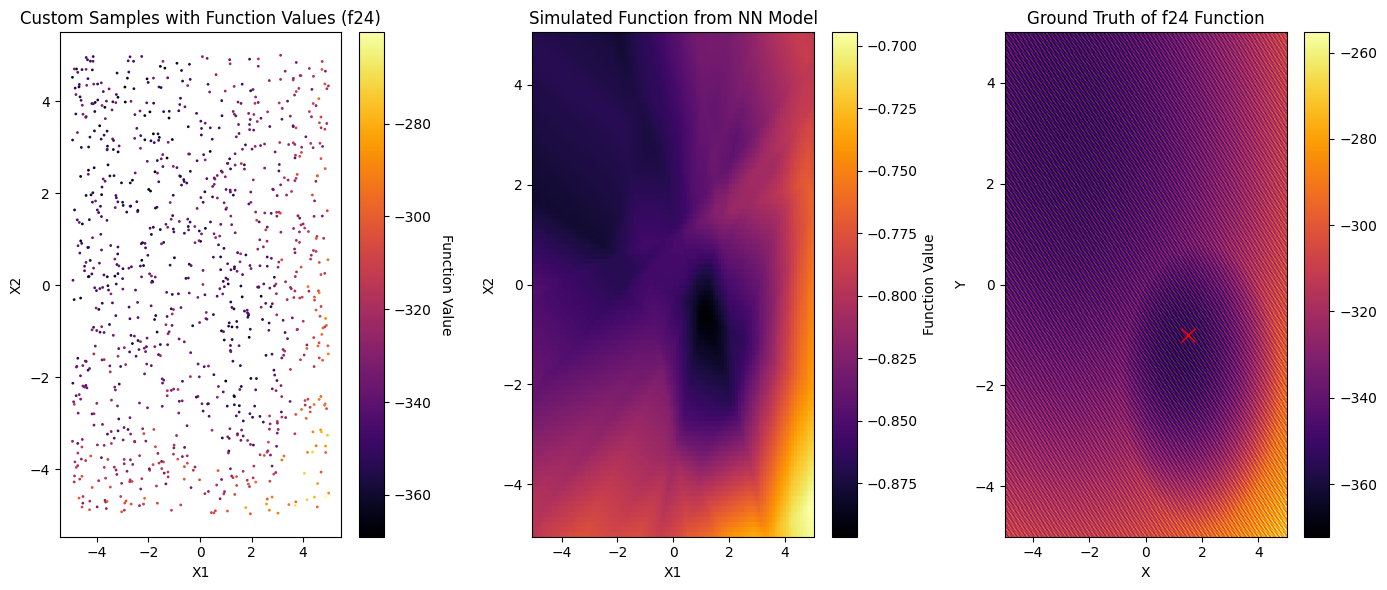

In [44]:
# Plot the sampled points
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plot_sampled_data(samples, results, problem_name)

# Plot the predicted function values using a contour plot
plt.subplot(1, 3, 2)
plot_simulated_meshgrid(X, Y, mesh_results, "NN Model")


# Plot the ground truth using a contour plot
plt.subplot(1, 3, 3)
plot_ground_truth(f_name=problem_name)


plt.tight_layout()
plt.show()

## Simulation with Monte Carlo Simulation


XXX until now just taken from the internet

In [53]:
# Use Gaussian Process Regression to approximate the function
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the Gaussian Process Regression model to the Monte Carlo samples
gpr_model.fit(monte_carlo_samples, monte_carlo_results)

# Generate a mesh grid for plotting the approximated function
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)
mesh_samples = np.c_[X.ravel(), Y.ravel()]

# Predict function values using the GPR model on the mesh grid
mesh_results, _ = gpr_model.predict(mesh_samples, return_std=True)
mesh_results = mesh_results.reshape(X.shape)

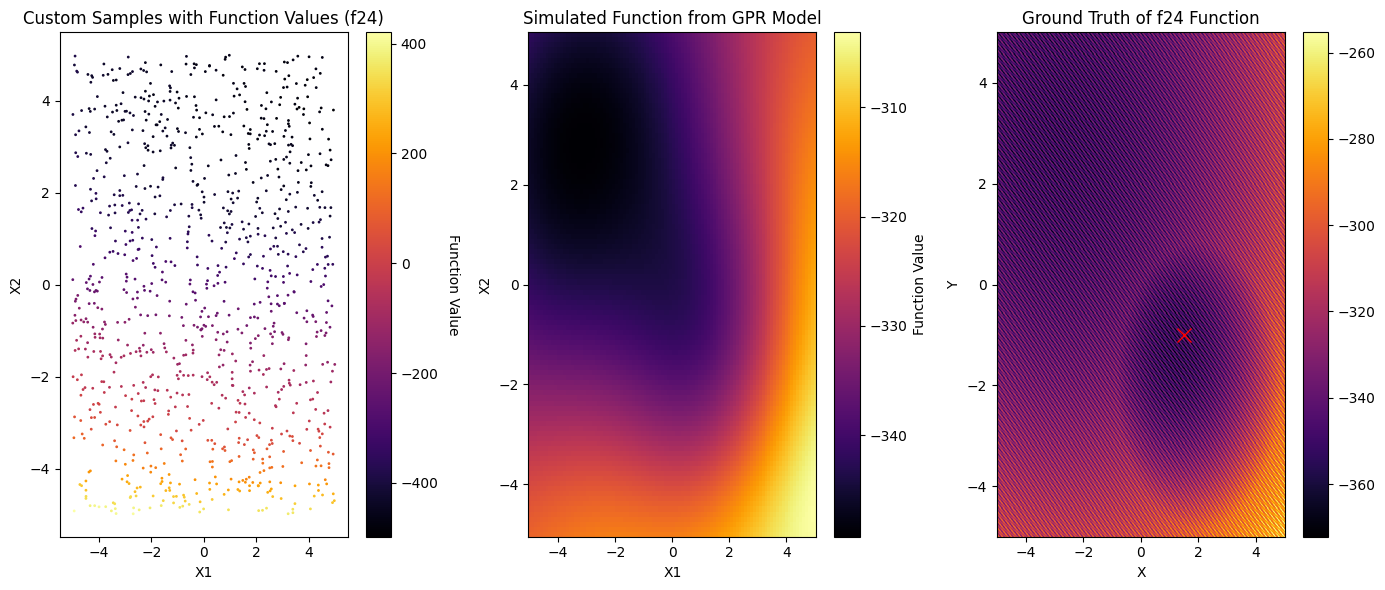

In [ ]:
# Plot the sampled points
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plot_sampled_data(monte_carlo_samples, monte_carlo_results, problem_name)


# Plot the predicted function
plt.subplot(1, 3, 2)
plot_simulated_meshgrid(X, Y, mesh_results, "GPR Model")

# Plot the ground truth function
plt.subplot(1, 3, 3)
plot_ground_truth(f_name=problem_name)

plt.tight_layout()
plt.show()

## Simulation with Support Vector Regression

In [47]:
from sklearn.svm import SVR

In [48]:
# simulate the function with the aboth samples and results
X_svc = samples
y_svc = results.float()
model_name = "SVR Model"

In [49]:
# define svr model
# XXX parameters are not optimized
svr_model = SVR(kernel='sigmoid', C=1.0, epsilon=0.1)

# Fit the SVR model to the Monte Carlo samples
svr_model.fit(X_svc, y_svc)


SVR()

In [50]:
#Generate a mesh grid for plotting the approximated function
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)
mesh_samples = np.c_[X.ravel(), Y.ravel()]

# Predict function values using the SVR model on the mesh grid
mesh_results = svr_model.predict(mesh_samples)
mesh_results = mesh_results.reshape(X.shape)

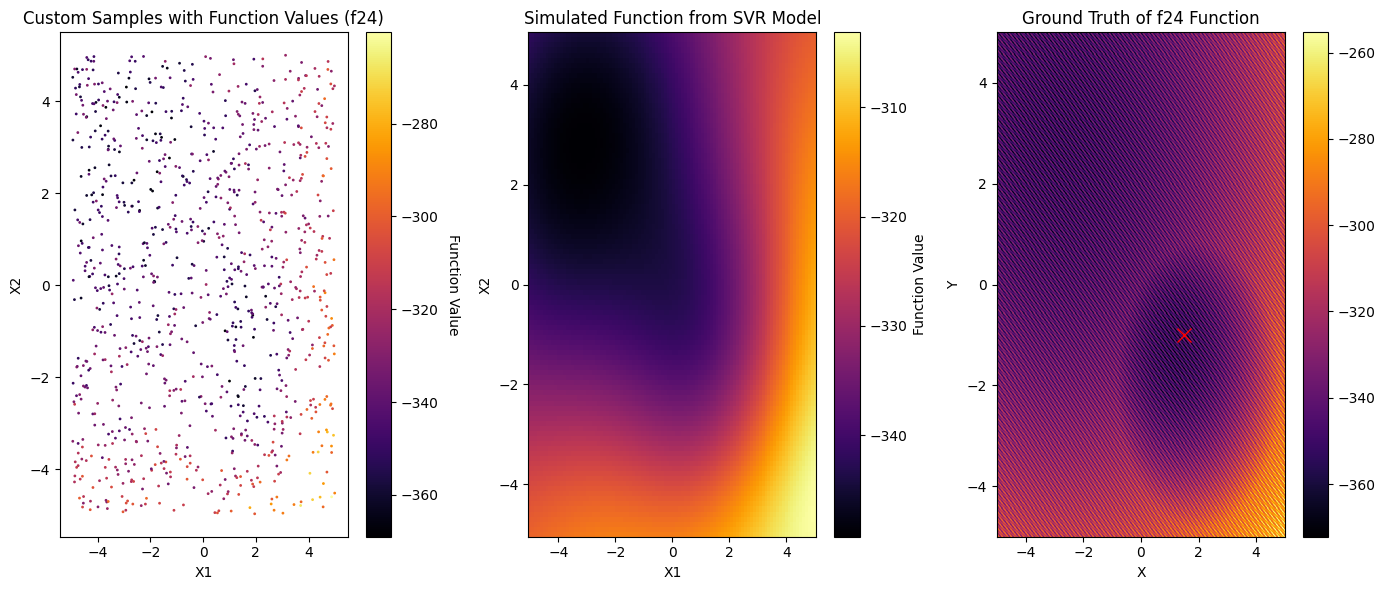

In [51]:
# Plot the sampled points
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plot_sampled_data(X_svc, y_svc, problem_name)

# Plot the approximated function from SVR
plt.subplot(1, 3, 2)
plot_simulated_meshgrid(X, Y, mesh_results, model_name)


# Plot the ground truth function
plt.subplot(1, 3, 3)
plot_ground_truth(f_name=problem_name)


plt.tight_layout()
plt.show()